In [ ]:
import pandas as pd
import requests
import bs4

In [ ]:
current_dep_scrape = 'http://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=9&district=y'



In [ ]:
links = [{'name':'2002', 'year':2012, 'link': 'https://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=5&district=y'},
{'name':'2012','year':2014, 'link':'https://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=8&district=y'},
 {'name':'2014','year':2019, 'link':'http://w1.c1.rada.gov.ua/pls/site2/fetch_mps?skl_id=9&district=y'}]


my_data = {};
for election in links:
    soup = bs4.BeautifulSoup(requests.get(election['link']).content)

    a = [d.text for d in soup.select('ul li p.title a')]
    b = [d.text.split('№')[1] for d in soup.select('ul li dd') if 'округу' in d.text]
    c = election['year']

    my_data[election['name']] = pd.DataFrame({'full_name': a,'smd': b, 'year':c})
    


In [ ]:
previous_winners = pd.concat(list(my_data.values()), axis=0)

In [ ]:
previous_winners.to_csv('previous_winners.csv', index=False)

In [ ]:
subv_2018 = pd.read_csv('https://raw.githubusercontent.com/OPORA/rada/master/subventions/subventions2018/MPs2018.csv')
subv_2018_short = subv_2018[['smd', 'amount']]

In [ ]:
parl = pd.read_csv('parl_2019.csv')

In [ ]:
parl['Висування'].value_counts().reset_index().to_csv('parties_2019', index=False)

In [ ]:
pres = pd.read_csv('pres_2019.tsv', sep='\t')
pres_tvo = pres.groupby(['tvo', 'oblast'])['БалашовГеннадій',
       'БезсмертнийРоман', 'БогомолецьОльга', 'БогословськаІнна', 'БойкоЮрій',
       'БондарВіктор', 'ВащенкоОлександр', 'ВілкулОлександр', 'ГаберМикола',
       'ГриценкоАнатолій', 'ДанилюкОлександр', 'Дерев’янкоЮрій',
       'ЖуравльовВасиль', 'ЗеленськийВолодимир', 'КаплінСергій',
       'КармазінЮрій', 'КиваІлля', 'КорнацькийАркадій', 'КошулинськийРуслан',
       'КривенкоВіктор', 'КупрійВіталій', 'ЛитвиненкоЮлія', 'ЛяшкоОлег',
       'МорозОлександр', 'НаливайченкоВалентин', 'НасіровРоман', 'НовакАндрій',
       'НосенкоСергій', 'ПетровВолодимир', 'ПорошенкоПетро', 'РиговановРуслан',
       'СкоцикВіталій', 'СмешкоІгор', 'СоловйовОлександр', 'ТарутаСергій',
       'ТимошенкоЮлія', 'ТимошенкоЮрій', 'ШевченкоІгор', 'ШевченкоОлександр'].sum()

pres_tvo.reset_index(inplace=True)

In [ ]:
party_names_and_cands = parl['Висування'].value_counts().reset_index()
party_names_and_cands['candidat_pres'] =  pd.Series([np.nan,'ЗеленськийВолодимир', 'БойкоЮрій', 'ТимошенкоЮлія', np.nan, 'ПорошенкоПетро', np.nan, 'СмешкоІгор', np.nan, 'ЛяшкоОлег'])
# party_names_and_cands = party_names_and_cands.fillna('Самовисування')

In [ ]:
pres_tvo_melted = pd.melt(pres_tvo,id_vars=['tvo', 'oblast'],
        value_name='n_vbtes')

In [ ]:
party_names_and_cands.columns

In [ ]:
parl_with_pres_name = pd.merge(parl, party_names_and_cands[['index', 'candidat_pres']],
         left_on='Висування', right_on="index", how='left')

In [ ]:
# parl_with_pres_name['Округ', 'candidat_pres']
# pres_tvo_melted['tvo', 'variable']

In [ ]:
data_for_prediction = pd.merge(parl_with_pres_name, pres_tvo_melted, left_on=['Округ', 'candidat_pres'],
         right_on=['tvo', 'variable'], how='left')

In [ ]:
data_for_prediction = data_for_prediction[['ПІБ', 'Округ', 'Висування', 'Область', 'n_vbtes']]
data_for_prediction.columns = ['candidat_name', 'tvo', 'party_name', 'oblast_name', 'pres_cand_result']
data_for_prediction

In [ ]:
subv_2018['smd'] = subv_2018.smd.astype('str')
combined_subv = pd.merge(subv_2018[['smd', 'mp_name', 'amount']], winners_2019, on='smd', how='left')

In [ ]:
data_for_prediction['tvo'] = data_for_prediction.tvo.astype('str') 
merged_subv = pd.merge(data_for_prediction, combined_subv,
         left_on=['tvo'], right_on=['smd'], how='left')

In [ ]:
merged_subv[merged_subv.compare > 0.85].sort_values('compare')

In [ ]:
# помилка тому, що є НА в назвах, а вони є тому, що субвенції були не у всіх округах. Краще на це забити і взяти 
# переможців з попереднього файла

from difflib import SequenceMatcher

merged_subv.full_name = merged_subv.full_name.fillna('1')

def compare(x):
    return SequenceMatcher(None, x['candidat_name'], x['full_name']).ratio()

merged_subv['compare'] = merged_subv.apply(lambda x: compare(x), axis=1)
merged_subv['winner'] = merged_subv.compare.apply(lambda x: x > 0.9)


In [ ]:
np.nan

In [ ]:
def change(x):
    if (x['winner'] == True):
        return x['amount']
    else:
        return np.nan
        

merged_subv['amount'] = merged_subv.apply(lambda x: change(x), axis=1)

In [ ]:
merged_subv_short =  merged_subv.drop(['mp_name', 'full_name', 'compare'], axis=1)
merged_subv_short.columns = ['candidat_name', 'tvo', 'party_name', 'oblast_name', 'pres_cand_result',
       'smd', 'amount', 'previous_election_winner']
merged_subv_short.to_csv('for_2019_pred_unfinished.csv', index=False)

In [ ]:
merged_subv['winner'] = merged_subv.compare.apply(lambda x: x > 0.9)

In [ ]:
merged_subv_short

In [ ]:
merged_subv_short[merged_subv_short.party_name == 0]

In [ ]:
load_csv.iloc[2,:]

# Model

In [ ]:
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 6)

In [ ]:
# load_csv = "combined_results.csv"  # modify this for your machine

# load_csv = pd.read_csv(load_csv)


In [ ]:
# t = load_csv.loc[load_csv.winner == True]
# f = load_csv.loc[load_csv.winner == False]

# f_short = f.sample(len(t))

In [ ]:
loan_csv = "combined_results.csv"  # modify this for your machine
# Alternatively, you can import the data directly from a URL
# loan_csv = "https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv"
# data = h2o.H2OFrame(data)  # 163,987 rows x 15 columns

# df = pd.read_csv(loan_csv)
# df = df.drop_duplicates()

# previous_winners['was_in_power'] = True
# previous_winners.columns = ['deputat', 'tvo', 'year', 'was_in_power']
# previous_winners.tvo = previous_winners.tvo.astype('int64')

# df = pd.merge(df, previous_winners, on=['deputat', 'tvo', 'year'], how='left')
# df.was_in_power = df.was_in_power.fillna(False)


# data = h2o.H2OFrame(df)
data = h2o.import_file(loan_csv)

In [ ]:
# train_pd = df.loc[df.year == 2012]
# test_pd = df.loc[df.year == 2014]


In [ ]:
# from sklearn.utils import shuffle

# t = train_pd.loc[load_csv.winner == True]
# f = train_pd.loc[load_csv.winner == False]

# f_short = f.sample(len(t))

# d = pd.concat([t,f_short], axis=0)
# train_pd_short = shuffle(d)


# train = h2o.H2OFrame(train_pd_short)
# test = h2o.H2OFrame(test_pd)

In [ ]:
data = data.drop(['perc_for', 'votes_for'])

In [ ]:
# Partition data into 70%, 15%, 15% chunks
# Setting a seed will guarantee reproducibility

# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

# train = data_prepared[data_prepared[:,'year'] == 2012]
# test = data_prepared[data_prepared[:,'year'] == 2014]

Identify response and predictor variables¶ 

In [ ]:
y = 'winner'
x = list(data.columns)

x.remove(y)  #remove the response
x.remove('pres_perc_for')  #remove the interest rate column because it's correlated with the outcome



In [ ]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [ ]:
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', max_depth=10, seed=1)

In [ ]:
rf_fit1.train(x=x, y=y, training_frame=train)

Train an RF with more trees¶

In [ ]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

In [ ]:
# rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
# rf_fit3.train(x=x, y=y, training_frame=data)

In [ ]:
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(
#     silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
#                       objective='binary:logistic', 
#                       n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
gamma=10.0)
model.train(x=x, y=y, training_frame=train)

In [ ]:
xgboost_perf1 = model.model_performance(test)


In [ ]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)
# rf_perf3 = rf_fit3.model_performance(test)
xgboost_perf1 = model.model_performance(test)


# Retreive test set AUC
print (rf_perf1.auc())
print (rf_perf2.auc())
xgboost_perf1.auc()

# print (rf_perf3.auc())




In [ ]:
xgboost_perf1

In [ ]:
rf_perf1.confusion_matrix()


In [ ]:
pd.DataFrame(model.varimp()) 

In [ ]:
final_pred = rf_fit2.predict(test.drop('winner'))


In [ ]:
test[170,]

In [ ]:
import sys
sys.getdefaultencoding()


In [ ]:
test.as_data_frame()

In [ ]:
check_result = test.concat(final_pred,axis=1).as_data_frame(use_pandas=True)



In [ ]:
def check(x):
    if (x['predict'] == x['winner'] == True):
        return 'true_positive'
    if (x['predict'] == x['winner'] == False):
        return 'true_negative'
    if (x['predict'] > x['winner']):
        return "false_positive"
    if (x['predict'] < x['winner']):
        return 'false_negative'

check_result['status'] = check_result.apply(lambda x: check(x), axis=1)

In [ ]:
check_result.winner.value_counts()

In [ ]:
check_result.status.value_counts()

In [ ]:
check_result

In [ ]:
highest_prob = check_result.groupby(['tvo', 'year'], sort=False)['True'].max().reset_index(name='highest_prob')

check_result = pd.merge(check_result, highest_prob, on=['tvo', 'year'], how='left')

In [ ]:
check_result.predict.value_counts()

In [ ]:
len(check_result)

In [ ]:
check_result['manual_check_winner'] = check_result.apply(lambda x: x['True'] == x['highest_prob'], axis=1)

In [ ]:
check_result[check_result.apply(lambda x: (x['winner'] != x['manual_check_winner']), axis=1)].proposed.value_counts()

In [ ]:
check_result.loc[check_result.tvo == 25].sort_values('True', ascending=False)[['True', 'deputat', 'partia','manual_check_winner', 'winner']]

In [ ]:
check_result[(check_result.winner == True) & (check_result.manual_check_winner == False)]

In [ ]:
check_result[check_result.manual_check_winner != check_result.winner].partia.value_counts()

## gradient boosting

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

In [ ]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

In [ ]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

# not h2o

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
data = pd.read_csv('combined_results.csv')

In [ ]:
# from sklearn.utils import shuffle
# data_t = data[data.winner == True]

# data_f = data[data.winner == False]

# data_f_short = data_f.sample(len(data_f))
# data_for_model = pd.concat([data_t, data_f_short], axis=0)


In [ ]:
data_dummy = pd.get_dummies(data, prefix_sep='_', drop_first=True)

In [ ]:
Y = data_dummy[['winner']]
X = data_dummy.drop(['winner', 'perc_for', 'votes_for'], axis=1)

In [ ]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
# X_train = pd.get_dummies(X_train, prefix_sep='_', drop_first=True)
# X_test = pd.get_dummies(X_test, prefix_sep='_', drop_first=True)

In [ ]:
# fit model no training data
model = XGBClassifier(
#     learning_rate =0.007,
#     n_estimators=1000,
#     max_depth = 3,
#     min_child_weight = 5,
#     gamma=0.4,
#     subsample=0.55,
#     colsample_bytree=0.85,
#     reg_alpha=0.005,
#     objective= 'binary:logistic',
#     nthread=2,
    scale_pos_weight=13,
)
model.fit(X_train, y_train)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

# Performance sur le train
auc = roc_auc_score(y_train, model.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_test, model.predict(X_test))
print("Performance sur le test : ", auc)

In [ ]:
pred = model.predict_proba(X_test)

In [ ]:
pred

In [ ]:
pred[:5,1]

In [ ]:
sum([0.37040956, 0.13334107, 0.22757675, 0.13501285, 0.1])

In [ ]:
import bisect

loi = [0, 0.1, 0.13334107, 0.13501285, 0.22757675, 0.37040956, 1]
index = bisect.bisect_left(loi, 0.9)

In [ ]:
loi[index]

In [ ]:
loi[index-1], loi[index]

In [ ]:
import numpy as np

In [ ]:
np.array([1,2,3]) < np.array([[4,0.5,6],[4,0.5,1] ])

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from sklearn.metrics import confusion_matrix
# 
# confusion_matrix(y_test, np.random.choice(a=[False, True], size=(1961,), p=[1-0.07445181030086691, 0.07445181030086691]))
confusion_matrix(y_test, y_pred)


In [ ]:
y_test.winner.value_counts()

In [ ]:
sum(y_test.values)
146/1961 * 100

In [ ]:
100-7.445181030086691 + 7.445181030086691

In [ ]:
len(y_test.values)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("combined_results_cleaned.csv")

In [ ]:
year_2012 = df.loc[(df.year == 2012) & (df.winner == True)][['deputat', 'year', 'tvo', 'birthday']]
year_2014 = df.loc[(df.year == 2014) & (df.winner == True)][['deputat', 'year', 'tvo', 'birthday']]

year_2012['fixed_previous'] = True
year_2014['fixed_previous'] = True

year_2012['year'] = 2014
year_2014['year'] = 2019


year_2012_2014 = pd.concat([year_2012, year_2014])


In [ ]:
temp = pd.merge(df, year_2012_2014, on=['deputat', 'year', 'tvo', 'birthday'], how='left')

In [ ]:
temp[(~temp.fixed_previous.isnull()) & (temp.year == 2019)].proposed.value_counts()

In [ ]:
temp[(temp.year == 2012) & (temp.funding > 0)].winner.value_counts()

In [ ]:
def check_funding(x):
    if (x['fixed_previous'] == True):
        return x['funding']
    if((x['year'] == 2012) & (x['proposed'] == 'партія регіонів')):
        return x['funding']
    else:
        return 0

temp['funding_fixed'] = temp.apply(check_funding, axis=1)

In [ ]:
temp.loc[(temp.funding_fixed > 0) & (temp.year == 2019)].oblast.value_counts()

In [ ]:
temp[temp.fixed_previous == True]

In [ ]:
temp.to_csv('combined_results_cleaned.csv', index=False)

## model new data

In [ ]:
df = pd.read_csv('combined_results_cleaned.csv')

In [ ]:
df.loc[df.year == 2012]

In [ ]:
df.prop_election_forecast.unique()


{30.7:30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
       21.3,  6.3}

In [ ]:
for d in ['proposed', 'gender', 'job', 'city_living', 'party', 'tvo_pres',
 'pres_candidate', 'region_ideology', 'party_ideology', 'oblast']:
    df[d] = df[d].astype('category')

In [ ]:
train.columns

In [ ]:
train = df.loc[df.year < 2019]
winners = train[['winner', 'perc_for']]
train = train.drop(['deputat', 'winner', 'registration','tvo_pres', 'birthday', 'perc_for', 'votes_for', 'year', 'info', 'funding', 'previous', 'pres_votes_for'],
                   axis=1)

predict_set = df.loc[df.year == 2019]
predict_set = predict_set.drop(['deputat','winner', 'registration','tvo_pres', 'birthday', 'perc_for', 'votes_for', 'year', 'info', 'funding', 'previous', 'pres_votes_for'],
                   axis=1)

In [ ]:
train_set_dummy = pd.get_dummies(train, prefix_sep='_', drop_first=True)
predict_set_dummy = pd.get_dummies(predict_set, prefix_sep='_', drop_first=True)

In [ ]:
# fit model no training data
model = XGBClassifier(
#     learning_rate =0.007,
#     n_estimators=1000,
#     max_depth = 3,
#     min_child_weight = 5,
#     gamma=0.4,
#     subsample=0.55,
#     colsample_bytree=0.85,
#     reg_alpha=0.005,
#     objective= 'binary:logistic',
#     nthread=2,
    scale_pos_weight=13,
)
model.fit(train_set_dummy, winners.winner)

In [ ]:
predictions = model.predict_proba(predict_set_dummy)

In [ ]:
predicted_data = df.loc[df.year == 2019]
predicted_data['true_prob'] = predictions[:,1]

## modeling by party

In [65]:
import pandas as pd

predicted_data_five = pd.read_csv('predicted_data_five.csv')

In [66]:
predicted_data_five = (predicted_data.sort_values('true_prob', ascending=False)
                           .groupby('tvo').head(5).sort_values('tvo'))

NameError: name 'predicted_data' is not defined

In [67]:
predicted_data_five['true_prob_sum'] = predicted_data_five.groupby('tvo')['true_prob'].transform(sum)

In [68]:
predicted_data_five['true_prob_two_1'] = predicted_data_five.true_prob/ predicted_data_five.true_prob_sum 

In [ ]:
# predicted_data_five.to_csv('predicted_data_five.csv', index=False)

In [69]:
prob = (predicted_data_five.sort_values('true_prob_two_1').groupby('tvo')
     .apply(lambda x: [list(x['true_prob_two_1'].values), list(x['proposed'].values)]).reset_index(name = 'prob'))

In [ ]:
prob['party_list'] = prob.prob.str[1]
prob['prob'] = prob.prob.str[0]

In [ ]:

prob['prob_full'] = prob['prob'] + np.random.normal(0.00001, 0.00002,size=1)

In [ ]:
random_modeling = [np.random.normal(0.5, 0.25,size=10000) for a in range(0,199)]

In [ ]:
from tqdm import tqdm_notebook as tqdm

res = []
for a in tqdm(range(0,len(prob.prob_full))):
    res.append([min(prob.prob_full[a], key=lambda x:abs(x-b)) for b in random_modeling[a]])


In [ ]:
prob['res'] = res

In [ ]:
def find_winner_party(x):
    dictionary = dict(zip(x['prob_full'], x['party_list']))
    return [dictionary[d] for d in x['res']]
    

prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

In [ ]:
final = []
for number in tqdm(range(0,9999)):
    final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
     'n': prob.winner_party.str[number].value_counts().values,
     'trial': number
    }))

In [ ]:
final_df = pd.concat(final)



In [ ]:
# as functions

In [43]:
def modeling_parties_as_function(df, col_name):
    from tqdm import tqdm_notebook as tqdm
    
    def check_if_smaller(list_of_pred, number):
        list_of_pred = list_of_pred[::-1]
        if (list_of_pred[0] > number):
            return list_of_pred[0]
        if (list_of_pred[0] + list_of_pred[1] > number):
            return list_of_pred[1]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] > number):
            return list_of_pred[2]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] + list_of_pred[3] > number):
            return list_of_pred[3]
        else:
            return list_of_pred[4]
    
    
#     for full data, to get top 5 results
#     df = (df.sort_values(col_name, ascending=False)
#                            .groupby('tvo').head(5).sort_values('tvo'))
    
    df['true_prob_sum'] = df.groupby('tvo')[col_name].transform(sum)
    df['true_prob_two_1'] = df[col_name] / df.true_prob_sum 

    prob = (df.sort_values('true_prob_two_1').groupby('tvo')
                 .apply(lambda x: [list(x['true_prob_two_1'].values), 
                                   list(x['proposed'].values),
                                    list(x['deputat'])]
                        ).reset_index(name = 'prob'))

    prob['prob'] = prob.prob.str[0]
    prob['party_list'] = prob.prob.str[1]
    prob['deputat'] = prob.prob.str[2]


#     generating random trials
    random_modeling = [np.random.normal(0.5, 0.25,size=10000) for a in range(0,199)]
    
#     for situation with the same probability
    prob['prob_full'] = prob['prob'] + np.random.normal(0.00001, 0.00002,size=1)


    res = []
    for a in tqdm(range(0,len(prob.prob_full))):
        res.append([check_if_smaller(prob.prob_full[a], b) for b in random_modeling[a]])


    prob['res'] = res

    def find_winner_party(x):
        dictionary = dict(zip(x['prob_full'], x['party_list']))
        return [dictionary[d] for d in x['res']]


    prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

    final = []
    for number in tqdm(range(0,10000)):
        final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
         'n': prob.winner_party.str[number].value_counts().values,
         'trial': number
        }))


    final_df = pd.concat(final)
    return final_df




In [44]:
final_df = modeling_parties_as_function(predicted_data_five, 'true_prob')

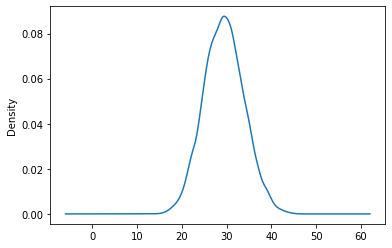

In [64]:
final_df[final_df.name == 'політична партія всеукраїнське обєднання свобода'].n.plot.density()

In [24]:
df = pd.read_csv('combined_results_cleaned.csv')

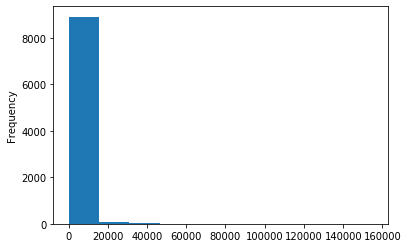

In [25]:
df.funding.plot.hist()

In [31]:
df.prop_election_forecast.unique()

array([30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
       21.3,  6.3,  8.3, 12. ,  3.9, 45.5,  7.2,  6.6])

In [16]:
df.loc[(df.year == 2012) & (df.winner == True)].proposed.value_counts()

партія регіонів                                                                     115
самовисування                                                                        45
політична партія всеукраїнське обєднання батьківщина                                 40
політична партія всеукраїнське обєднання свобода                                     12
політична партія удар український демократичний альянс за реформи віталія кличка      6
політична партія єдиний центр                                                         3
народна партія                                                                        2
радикальна партія олега ляшка                                                         1
партія союз                                                                           1
Name: proposed, dtype: int64

In [14]:
import pandas as pd
df = pd.read_csv('combined_results_cleaned.csv')

In [13]:
df

,deputat,perc_for,votes_for,tvo,oblast,year,info,proposed,registration,gender,...,winner,average_age,pop_change,region_ideology,previous,ever,funding,power_status,party_ideology,prop_election_forecast
0,Дзоз Віталіна Олексіївна,38.76,27937.0,1,Автономна Республіка Крим,2012,народилася 16 листопада 1955 року в місті Крив...,партія регіонів,2012-08-07,F,...,True,40.4,1.1,blue,False,False,0,yes,blue,30.7
1,Грач Леонід Іванович,17.98,12960.0,1,Автономна Республіка Крим,2012,народився 1 сiчня 1948 року в селі Бродецьке К...,самовисування,2012-08-03,M,...,False,40.4,1.1,blue,True,True,0,no,grey,NaN
2,Соломахін Олег Андрійович,10.58,7630.0,1,Автономна Республіка Крим,2012,"народився 24 червня 1960 року в місті Херсоні,...",комуністична партія україни,2012-08-03,M,...,False,40.4,1.1,blue,False,False,0,yes,blue,12.9
3,Аксенов Сергій Валерійович,9.12,6575.0,1,Автономна Республіка Крим,2012,народився 26 листопада 1972 року в місті Бєльц...,політична партія руська єдність,2012-08-15,M,...,False,40.4,1.1,blue,False,False,0,no,blue,NaN
4,Доценко Сергій Миколайович,6.71,4838.0,1,Автономна Республіка Крим,2012,народився 27 липня 1979 року в селі Ромашкине ...,політична партія удар український демократични...,2012-08-09,M,...,False,40.4,1.1,blue,False,False,0,no,orange,19.5
5,Лобачев Сергій Миколайович,6.22,4485.0,1,Автономна Республіка Крим,2012,народився 10 червня 1944 року в селі Абезь Інт...,політична партія всеукраїнське обєднання батьк...,2012-08-08,M,...,False,40.4,1.1,blue,False,False,0,no,orange,22.1
6,Семенова Лариса Іванівна,2.28,1646.0,1,Автономна Республіка Крим,2012,народилася 12 лютого 1954 року в місті Євпатор...,партія зелених україни,2012-08-13,F,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN
7,Толкачов Володимир Володимирович,1.55,1119.0,1,Автономна Республіка Крим,2012,народився 15 листопада 1964 року в місті Сімфе...,партія наталії королевської україна вперед,2012-08-11,M,...,False,40.4,1.1,blue,False,False,0,no,blue,NaN
8,Пузако Володимир Іванович,1.17,847.0,1,Автономна Республіка Крим,2012,народився 16 липня 1951 року в місті Біла Церк...,українська партія зелена планета,2012-08-14,M,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN
9,Волков Олександр Петрович,0.88,635.0,1,Автономна Республіка Крим,2012,народився 6 вересня 1946 року в радгоспі Перво...,самовисування,2012-08-10,M,...,False,40.4,1.1,blue,False,False,0,no,grey,NaN


In [8]:
df.prop_election_forecast.unique()

array([30.7,  nan, 12.9, 19.5, 22.1,  6.5, 23. ,  5.6, 13.2,  6.4,  7.6,
       21.3,  6.3,  8.3, 12. ,  3.9, 45.5,  7.2,  6.6])

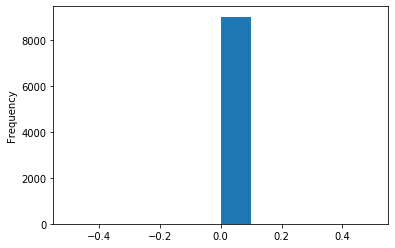

In [6]:
df.funding.plot.hist()

## final prediction distribution


In [81]:
import ipdb

def modeling_parties_as_function(df, col_name, number_of_winners, number_of_trials):
    from tqdm import tqdm_notebook as tqdm
    
    def check_if_smaller(list_of_pred, number):
#         list_of_pred = list_of_pred[::-1]
        if (list_of_pred[0] > number):
            return list_of_pred[0]
        if (list_of_pred[0] + list_of_pred[1] > number):
            return list_of_pred[1]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] > number):
            return list_of_pred[2]
        if (list_of_pred[0] + list_of_pred[1] + list_of_pred[2] + list_of_pred[3] > number):
            return list_of_pred[3]
        else:
            return list_of_pred[4]
        
        
    df['tvo'] = df.tvo.astype('object')

    
#     for full data, to get top 5 results
    df = (df.sort_values(col_name, ascending=False)
                           .groupby('tvo').head(number_of_winners).sort_values('tvo'))
    
    df['true_prob_sum'] = df.groupby('tvo')[col_name].transform(sum)
    df['true_prob_two_1'] = df[col_name] / df.true_prob_sum
    
    
    
    prob = (df.sort_values('true_prob_two_1', ascending=False).groupby('tvo')
                 .apply(lambda x: [list(x['true_prob_two_1'].values), 
                                   list(x['proposed'].values),
                                    list(x['deputat'])]
                        ).reset_index(name = 'prob'))
#     ipdb.set_trace()
    prob['prob_value'] = prob.prob.str[0]
    prob['party_list'] = prob.prob.str[1]
    prob['deputat'] = prob.prob.str[2]


#     generating random trials
    random_modeling = [np.random.normal(0.5, 0.25,size=number_of_trials) for a in range(0,199)]
    
#     for situation with the same probability
    prob['prob_full'] = prob['prob_value'] + np.random.normal(0.00001, 0.00002,size=1)


    res = []
    for a in (range(0,len(prob.prob_full))):
#         ipdb.set_trace()
        res.append([check_if_smaller(prob.prob_full[a], b) for b in random_modeling[a]])


    prob['res'] = res

    def find_winner_party(x):
#         ipdb.set_trace()
        dictionary = dict(zip(x['prob_full'], x['party_list']))
        return [dictionary[d] for d in x['res']]


    prob['winner_party'] = prob.apply(lambda x: find_winner_party(x), axis=1)

    final = []
    for number in (range(0,number_of_trials)):
        final.append(pd.DataFrame({'name':prob.winner_party.str[number].value_counts().index,
         'n': prob.winner_party.str[number].value_counts().values,
         'trial': number
        }))


    final_df = pd.concat(final)
    return final_df




In [431]:
pred = pd.read_csv('new_prediction.csv')

In [242]:
pred.loc[pred.proposed == 'самовисування', 'proposed'] =  pred.loc[pred.proposed == 'самовисування', 'fraction']

In [432]:
pred_modeling_150 = modeling_parties_as_function(pred, 'prediction_150', 5, 1000)
pred_modeling_100 = modeling_parties_as_function(pred, 'prediction_100', 5, 1000)
pred_modeling_50 = modeling_parties_as_function(pred, 'prediction_50', 5, 1000)
pred_modeling_default_plus_class = modeling_parties_as_function(pred, 'prediction_default_plus_class', 5, 1000)

In [424]:
def chart(party_name, title, color):
    import numpy as np
    import seaborn as sns; sns.set(color_codes=True)
    from matplotlib.ticker import MaxNLocator

    x = pred_modeling_default_plus_class[pred_modeling_default_plus_class.name == party_name].n

    # ax = sns.kdeplot(x)
    ax = sns.distplot(x, kde=False, color=color, bins=np.arange(x.min(), x.max() + 1))
    ax.set_title(title, weight='bold')
    ax.set(xlabel='')
    

    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    
    sns.set(rc={'figure.figsize':(4.2,2.4)})

    legend = ax.legend()
    legend.remove()

    ax.set(yticks=[])

In [ ]:
# chart('політична партія слуга народу', "Слуга Народу", 'green')
chart('самовисування', "Самовисуванці", 'grey')
# chart('політична партія опозиційна платформа  за життя', "Опозиційна Платформа - За Життя", 'blue')
# chart('політична партія європейська солідарність', "Європейська Солідарність", 'red')
# chart('політична партія голос', "Партія Голос", 'orange')
# chart('політична партія всеукраїнське обєднання батьківщина', "ВО Батьківщина", 'pink')


# дуже мало 
# chart('політична партія сила і честь', "Сила і Честь", 'violet')


No handles with labels found to put in legend.


In [170]:
samovys = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSNxiVppRf_pyTzKIXI-NA-5ncgsmjr8EmKSNUlarYzpdVC12ToK80zDjDXRkWvw_lmF6ng-yoTRMvP/pub?gid=812690743&single=true&output=csv')

In [177]:
temp = samovys.fraction.value_counts().reset_index(name='n')
temp['perc'] = temp.n/temp.n.sum() * 100

In [289]:
# pred_modeling_150.name.value_counts()

samov = [
'Член депутатської фракції ПАРТІЇ "БЛОК ПЕТРА ПОРОШЕНКА"', 
'Член депутатської фракції Політичної партії "НАРОДНИЙ ФРОНТ"',
'Член депутатської групи "Партія "Відродження"',
'Член депутатської групи "Воля народу"',
'Член депутатської фракції Політичної партії "Опозиційний блок"',
'Член депутатської фракції Радикальної партії Олега Ляшка',
]




In [287]:
pred_modeling_default_plus_class.groupby('name')['n'].median().reset_index(name='mean_n').sort_values('mean_n', ascending=False)

,name,mean_n
24,політична партія слуга народу,71
4,"Член депутатської фракції ПАРТІЇ ""БЛОК ПЕТРА П...",36
5,"Член депутатської фракції Політичної партії ""Н...",17
3,"Член депутатської групи ""Партія ""Відродження""",12
28,політична партія європейська солідарність,10
2,"Член депутатської групи ""Воля народу""",9
6,"Член депутатської фракції Політичної партії ""О...",7
18,політична партія опозиційна платформа за життя,7
12,політична партія голос,4
7,Член депутатської фракції Радикальної партії О...,3


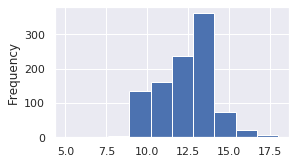

In [331]:
pred_modeling_default_plus_class.loc[pred_modeling_default_plus_class.name == 'Член депутатської групи "Партія "Відродження"'].n.plot.hist()

No handles with labels found to put in legend.


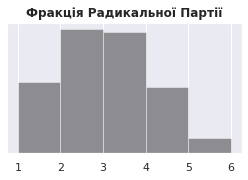

In [430]:
xz = samov
# chart(xz[0], 'Фракція БПП', 'red')
# chart(xz[1], 'Фракція Народного Фронту', 'yellow')
# chart(xz[2], 'Група Відродження', 'purple')
# chart(xz[3], 'Група Воля Народу', 'silver')
# chart(xz[4], 'Фракція Опозиційного Блоку', 'blue')
# chart(xz[5], 'Фракція Радикальної Партії', 'black')

